In [1]:
import numpy as np

from hoomd.neb_plugin import neb
import hoomd
import freud
import gsd.hoomd
from monk import pair, render

import matplotlib.pyplot as plt
from matplotlib import cm, colors
import matplotlib as mpl

In [2]:
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["axes.labelsize"] = "xx-large"

# Setup initial and final states

In [3]:
def make_snap(box, pos):
    snap = gsd.hoomd.Snapshot()
    snap.configuration.box = list(box.L) + [0, 0, 0]
    snap.configuration.dimensions = 2
    snap.particles.N = len(pos)
    snap.particles.position = pos
    snap.particles.types = ["A"]
    snap.particles.diameter = np.ones(len(pos))*0.5

    return snap

In [4]:
# prepare lattice with a defect

Nx = 10

snap_box, snap_pos = freud.data.UnitCell.hex().generate_system((Nx, Nx, 1), scale=0.5)

future_pos = np.copy(snap_pos)
mid = future_pos[Nx*Nx,:].copy()
future_pos[Nx*Nx,:] = future_pos[0,:]
# future_pos[Nx*(Nx+1),:] = mid

snap_pos = np.delete(snap_pos, 0, axis=0)
future_pos = np.delete(future_pos, 0, axis=0)

snap = make_snap(snap_box, snap_pos)
future_snap = make_snap(snap_box, future_pos)

sim = hoomd.Simulation(device=hoomd.device.CPU(), seed=10)
sim.create_state_from_snapshot(snap)
future_hoomd_snap = hoomd.Snapshot.from_gsd_snapshot(future_snap, sim.device.communicator)
future_sim = hoomd.Simulation(device=hoomd.device.CPU(), seed=15)
future_sim.create_state_from_snapshot(future_hoomd_snap)

In [5]:
ids = np.ravel(np.argwhere(np.linalg.norm(snap_pos - snap_pos[0, :], axis=-1) < 4)).astype(np.uint32)
print(len(ids))
filter = hoomd.filter.Tags(ids)

162


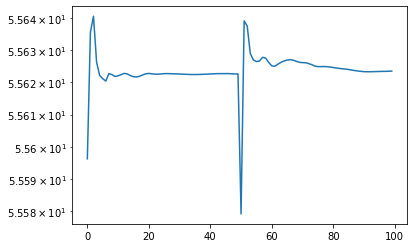

In [6]:
def setup_endpoint(sim: hoomd.Simulation, filter=None):

    nlist = hoomd.md.nlist.Cell(0.3)
    hertzian = pair.bi_hertz(nlist)
    forces = [hertzian]

    def setup_node(sim, k, forces, filter):
        neb_integrator = neb.NEB(0.01, 1e-3, 1e-3, 1e-3, k=k)
        if forces is not None:
            neb_integrator.forces = forces
        nve = hoomd.md.methods.DisplacementCapped(filter, 0.01)
        neb_integrator.methods = [nve]

        sim.operations.integrator = neb_integrator

        sim.run(0)

    if filter is None:
        filter = hoomd.filter.All()
    
    setup_node(sim, 1.0, forces, filter)

# filter=hoomd.filter.All()
setup_endpoint(sim, filter)
setup_endpoint(future_sim, filter)
start = sim
end = future_sim

start.operations.integrator.nudge = False
energy = []
start.state.thermalize_particle_momenta(hoomd.filter.All(), kT=1.0)
for i in range(50):
    start.run(100)
    energy.append(start.operations.integrator.energy)
start.operations.integrator.nudge = True

end.operations.integrator.nudge = False
end.state.thermalize_particle_momenta(hoomd.filter.All(), kT=1.0)
for i in range(50):
    end.run(100)
    energy.append(end.operations.integrator.energy)
end.operations.integrator.nudge = True

plt.plot(energy)
plt.yscale('log')

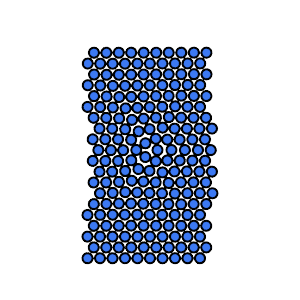

In [7]:
render.render_disk_frame(start.state.get_snapshot(), Nx*0.6*2)

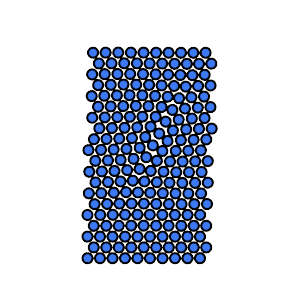

In [8]:
render.render_disk_frame(end.state.get_snapshot(), Nx*0.6*2)

In [9]:
start.operations.integrator.converged, end.operations.integrator.converged

(True, True)

In [10]:
filter

In [11]:
init_snap = start.state.get_snapshot()
final_snap = end.state.get_snapshot()

nlist = hoomd.md.nlist.Cell(0.3)
hertzian = pair.bi_hertz(nlist)
forces = [hertzian]

neb_driver = neb.NEBDriver(init_snap, final_snap, n_images=10, forces=forces, filter=filter)
neb_driver.k = 100.0

In [12]:
def d_omega(snap1, snap2):
    box = freud.box.Box.from_box(snap1.configuration.box)
    pos1 = snap1.particles.position
    pos2 = snap2.particles.position
    diff = box.wrap(pos2 - pos1)
    return np.linalg.norm(diff)

# Early phase of minimization looks good

Text(0.5, 0, 'Node i')

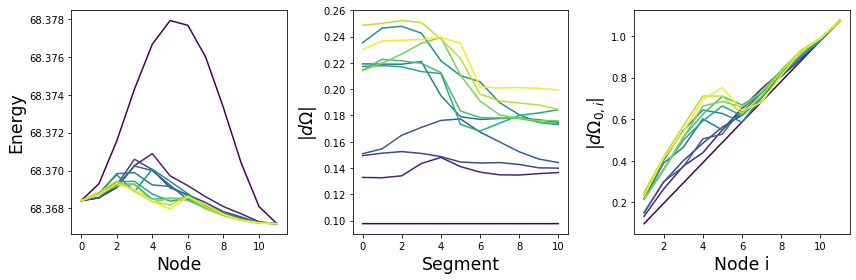

In [13]:
cmap = cm.viridis
runs = 10
norm = colors.Normalize(vmin=0, vmax=runs)

fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

energy = []
dists = []
other_dists = []
nodes = neb_driver.nodes
for i in range(len(nodes)-1):
    # print(len(sim.operations.integrator.forces))
    # sim.operations.integrator.reset()
    ps_dist = d_omega(nodes[i].state.get_snapshot(), nodes[i+1].state.get_snapshot())
    dists.append(ps_dist)
    energy.append(nodes[i].operations.integrator.forces[0].energy)
energy.append(nodes[-1].operations.integrator.forces[0].energy)

iter = list(range(1, len(nodes)))
for i in iter:
    ps_dist = d_omega(nodes[0].state.get_snapshot(), nodes[i].state.get_snapshot())
    other_dists.append(ps_dist)

axs[0].plot(energy, color=cmap(norm(0)))
axs[1].plot(dists, color=cmap(norm(0)))
axs[2].plot(iter, other_dists, color=cmap(norm(0)))

for j in range(1, runs+1):
    neb_driver.run(500)

    energy = []
    dists = []
    other_dists = []
    nodes = neb_driver.nodes
    for i in range(len(nodes)-1):
        # print(len(sim.operations.integrator.forces))
        # sim.operations.integrator.reset()
        ps_dist = d_omega(nodes[i].state.get_snapshot(), nodes[i+1].state.get_snapshot())
        dists.append(ps_dist)
        energy.append(nodes[i].operations.integrator.forces[0].energy)
    energy.append(nodes[-1].operations.integrator.forces[0].energy)

    iter = list(range(1, len(nodes)))
    for i in iter:
        ps_dist = d_omega(nodes[0].state.get_snapshot(), nodes[i].state.get_snapshot())
        other_dists.append(ps_dist)

    axs[0].plot(energy, color=cmap(norm(j)))
    axs[1].plot(dists, color=cmap(norm(j)))
    axs[2].plot(iter, other_dists, color=cmap(norm(j)))
axs[0].set_ylabel("Energy")
axs[0].set_xlabel("Node")
axs[1].set_ylabel(r"$|d\Omega|$")
axs[1].set_xlabel("Segment")
axs[2].set_ylabel(r"$|d\Omega_{0,i}|$")
axs[2].set_xlabel("Node i")

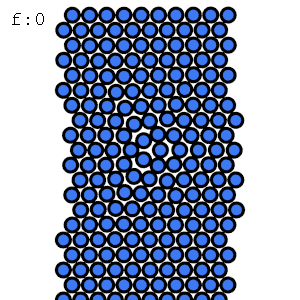

In [14]:
data = [n.state.get_snapshot() for n in neb_driver.nodes]

render.display_movie_from_list(render.render_disk_frame, data)

# Keep going longer

Text(0.5, 0, 'Node i')

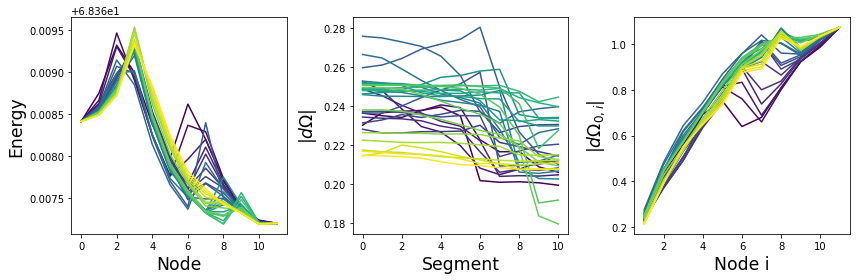

In [15]:
cmap = cm.viridis
runs = 30
norm = colors.Normalize(vmin=0, vmax=runs)

fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

energy = []
dists = []
other_dists = []
nodes = neb_driver.nodes
for i in range(len(nodes)-1):
    # print(len(sim.operations.integrator.forces))
    # sim.operations.integrator.reset()
    ps_dist = d_omega(nodes[i].state.get_snapshot(), nodes[i+1].state.get_snapshot())
    dists.append(ps_dist)
    energy.append(nodes[i].operations.integrator.forces[0].energy)
energy.append(nodes[-1].operations.integrator.forces[0].energy)

iter = list(range(1, len(nodes)))
for i in iter:
    ps_dist = d_omega(nodes[0].state.get_snapshot(), nodes[i].state.get_snapshot())
    other_dists.append(ps_dist)

axs[0].plot(energy, color=cmap(norm(0)))
axs[1].plot(dists, color=cmap(norm(0)))
axs[2].plot(iter, other_dists, color=cmap(norm(0)))

for j in range(1, runs+1):
    neb_driver.run(500)

    energy = []
    dists = []
    other_dists = []
    nodes = neb_driver.nodes
    for i in range(len(nodes)-1):
        # print(len(sim.operations.integrator.forces))
        # sim.operations.integrator.reset()
        ps_dist = d_omega(nodes[i].state.get_snapshot(), nodes[i+1].state.get_snapshot())
        dists.append(ps_dist)
        energy.append(nodes[i].operations.integrator.forces[0].energy)
    energy.append(nodes[-1].operations.integrator.forces[0].energy)

    iter = list(range(1, len(nodes)))
    for i in iter:
        ps_dist = d_omega(nodes[0].state.get_snapshot(), nodes[i].state.get_snapshot())
        other_dists.append(ps_dist)

    axs[0].plot(energy, color=cmap(norm(j)))
    axs[1].plot(dists, color=cmap(norm(j)))
    axs[2].plot(iter, other_dists, color=cmap(norm(j)))
axs[0].set_ylabel("Energy")
axs[0].set_xlabel("Node")
axs[1].set_ylabel(r"$|d\Omega|$")
axs[1].set_xlabel("Segment")
axs[2].set_ylabel(r"$|d\Omega_{0,i}|$")
axs[2].set_xlabel("Node i")

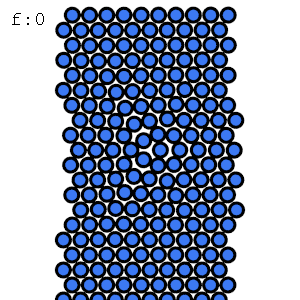

In [16]:
data = [n.state.get_snapshot() for n in neb_driver.nodes]

render.display_movie_from_list(render.render_disk_frame, data)